In [3]:
%pip install python-dotenv requests pandas

  Obtaining dependency information for python-dotenv from https://files.pythonhosted.org/packages/6a/3e/b68c118422ec867fa7ab88444e1274aa40681c606d59ac27de5a5588f082/python_dotenv-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/70/8e/0e2d847013cb52cd35b38c009bb167a1a26b2ce6cd6965bf26b47bc0bf44/requests-2.31.0-py3-none-any.whl.metadata
  Using cached requests-2.31.0-py3-none-any.whl.metadata (4.6 kB)
  Obtaining dependency information for charset-normalizer<4,>=2 from https://files.pythonhosted.org/packages/40/26/f35951c45070edc957ba40a5b1db3cf60a9dbb1b350c2d5bef03e01e61de/charset_normalizer-3.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for idna<4,>=2.5 from https://files.pythonhosted.org/packages/c2/e7/a82b05cf63a603df6e68d59ae6a68bf5064484a0718ea5033660af4b54a9/idna-3.6-py3-none-any.whl.metadata
  Obtaining dependency information for urllib3<3,>=1.

In [4]:
from dotenv import load_dotenv
import os
import requests
import json
import csv

# Load the .env file
load_dotenv()

# Get the value of the 'LM_API' environmental variable
lm_api = os.getenv('LM_API_KEY')
lm_hostname = os.getenv('LM_HOSTNAME')

# Set the headers for the request
headers = {
    "Authorization": f"Bearer {lm_api}"
}

## Plot monthly data

 * [ ]  Get the data from transactions and put it into a data frame
 * [ ]  Plot the data

         date    amount
0  2024-03-01   67.8000
1  2024-03-01   27.4000
2  2024-03-01  525.0000
3  2024-03-01  350.0000
4  2024-03-02   18.9500
6 transactions
Index(['id', 'date', 'amount', 'currency', 'to_base', 'payee', 'category_id',
       'category_name', 'category_group_id', 'category_group_name',
       'is_income', 'exclude_from_budget', 'exclude_from_totals', 'created_at',
       'updated_at', 'status', 'is_pending', 'notes', 'original_name',
       'recurring_id', 'recurring_payee', 'recurring_description',
       'recurring_cadence', 'recurring_type', 'recurring_amount',
       'recurring_currency', 'parent_id', 'has_children', 'group_id',
       'is_group', 'asset_id', 'asset_institution_name', 'asset_name',
       'asset_display_name', 'asset_status', 'plaid_account_id',
       'plaid_account_name', 'plaid_account_mask', 'institution_name',
       'plaid_account_display_name', 'plaid_metadata', 'source',
       'display_name', 'display_notes', 'account_display_name', 'tags

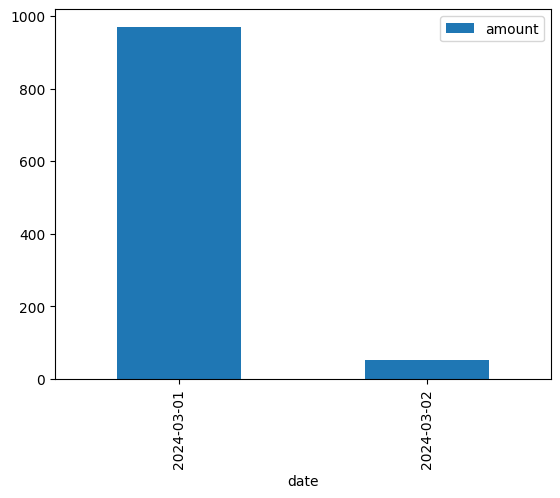

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


# using pandas, get the date of the start of the month and then the date of the previous month
today = pd.to_datetime('today')
start_of_this_month = today.replace(day=1)

url = f"{lm_hostname}/v1/transactions"

params = {
    "start_date": start_of_this_month.strftime('%Y-%m-%d'),
    "end_date": today.strftime('%Y-%m-%d')
}

response = requests.get(url, headers=headers, params=params)

# sum the amount of all the transactions for the current month
transactions = response.json()['transactions']
df = pd.DataFrame(transactions)

print (df[['date', 'amount']].head())

print(f"{len(transactions)} transactions")
print( df.keys())
print( df.dtypes)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['amount']=df['amount'].astype(float)

print (df[['date', 'amount']].head())


df['amount'].groupby(df['date'].dt.to_period('d')).sum().plot(kind='bar')


plt.show()


Plot the data in a chart